In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.io

import mne
from scipy.signal import coherence, hilbert

In [2]:
def metricas_grafo(G):
    # Métricas:
    # (a) Clustering promedio (coeficiente de agrupamiento)
    clust_coeff = nx.average_clustering(G)
    # (b) Longitud de camino promedio (camino más corto)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan  # red no conexa
    # (c) Small-worldness (ejemplo simplificado)
    # Comparar con grafo aleatorio de igual N, K
    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)
    
    # (d) Modularidad — usando método de comunidades
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)
    
    # (e) Hubs — grado, centralidad de intermediación
    degree_dict = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    
    # (f) Eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict

In [3]:
eeg_coords_csv = r"..\..\S03_datasets\EEG_practica\coordenadas_bipolares_eeg.csv"
eeg_coords = pd.read_csv(eeg_coords_csv)

eeg_coords.set_index("canal", drop=True, inplace=True)

In [4]:
edf_path = r"..\..\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13            # Banda alfa para la coherencia (puedes ajustar)

# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
eeg_data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_2804\4141082732.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [5]:
# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(eeg_data[i], eeg_data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

eeg_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
np.fill_diagonal(eeg_df.values, 0)

In [28]:
data = eeg_df.stack().values
threshold = np.percentile(data, 25)
threshold

np.float64(0.007686464269412794)

In [29]:
data = eeg_df[eeg_df>threshold].stack().values
df_filtered = eeg_df.where(eeg_df > threshold, 0)

# Generar grafo desde matriz
eeg_graph = nx.from_pandas_adjacency(df_filtered, create_using=nx.Graph())

clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict = metricas_grafo(eeg_graph)

hub = betweenness[0]

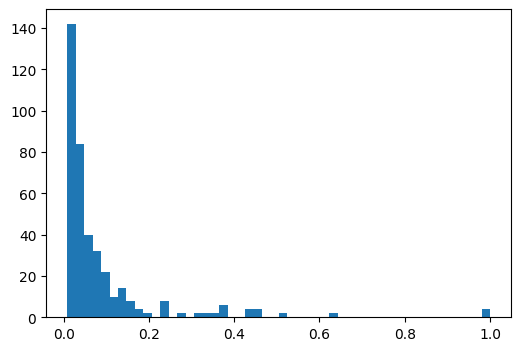

In [30]:
plt.figure(figsize=(6, 4))

plt.hist(data, bins=50)
plt.show()

In [32]:
communities

[frozenset({'C4-P4',
            'CZ-PZ',
            'F8-T8',
            'FT10-T8',
            'FT9-FT10',
            'P3-O1',
            'P4-O2',
            'P7-O1',
            'P7-T7',
            'P8-O2',
            'T7-P7',
            'T8-P8-0',
            'T8-P8-1'}),
 frozenset({'C3-P3',
            'F3-C3',
            'F4-C4',
            'F7-T7',
            'FP1-F3',
            'FP1-F7',
            'FP2-F4',
            'FP2-F8',
            'FZ-CZ',
            'T7-FT9'})]

In [33]:
betweenness

[('T8-P8-0', 0.01789523007055475),
 ('T8-P8-1', 0.01789523007055475),
 ('FZ-CZ', 0.016255155378532),
 ('CZ-PZ', 0.014906089581414254),
 ('FT9-FT10', 0.013664077625116584),
 ('F3-C3', 0.01306659309906063),
 ('C3-P3', 0.01306659309906063),
 ('F4-C4', 0.012493729214508434),
 ('C4-P4', 0.010934309797946162),
 ('FP2-F4', 0.01048400853595659),
 ('T7-FT9', 0.010395316564147734),
 ('P4-O2', 0.009866654509511652),
 ('T7-P7', 0.009220631460891202),
 ('P7-T7', 0.009220631460891202),
 ('F8-T8', 0.008877588260705145),
 ('P3-O1', 0.008448501954995464),
 ('P8-O2', 0.00824283941167058),
 ('FP1-F3', 0.007947013304156161),
 ('FP1-F7', 0.007521825216630411),
 ('FP2-F8', 0.005996582782297067),
 ('F7-T7', 0.004677267177267177),
 ('FT10-T8', 0.00420630956345242),
 ('P7-O1', 0.002813059955917098)]

In [34]:
hub

('T8-P8-0', 0.01789523007055475)

In [36]:
communities

[frozenset({'C4-P4',
            'CZ-PZ',
            'F8-T8',
            'FT10-T8',
            'FT9-FT10',
            'P3-O1',
            'P4-O2',
            'P7-O1',
            'P7-T7',
            'P8-O2',
            'T7-P7',
            'T8-P8-0',
            'T8-P8-1'}),
 frozenset({'C3-P3',
            'F3-C3',
            'F4-C4',
            'F7-T7',
            'FP1-F3',
            'FP1-F7',
            'FP2-F4',
            'FP2-F8',
            'FZ-CZ',
            'T7-FT9'})]

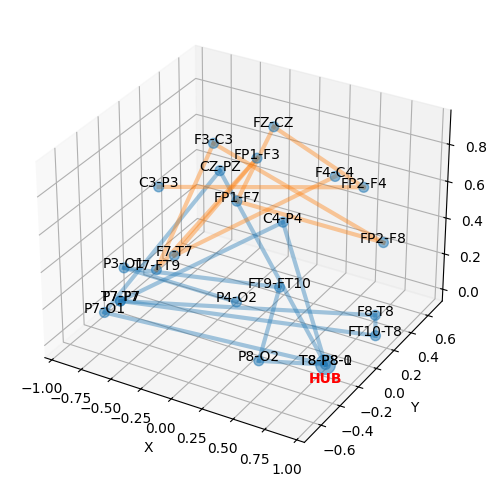

In [35]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# %matplotlib widget
# Creamos el plot3D del grafo
x, y, z = eeg_coords.loc[:, 'x'].values, eeg_coords.loc[:, 'y'].values, eeg_coords.loc[:, 'z'].values
colors = [
    'tab:blue',      # azul
    'tab:orange',    # naranja
    'tab:green',     # verde
    'tab:red',       # rojo
    'tab:purple',    # morado
    'tab:brown',     # café
    'tab:pink',      # rosa
    'tab:gray',      # gris
    'tab:olive',     # verde oliva
    'tab:cyan',      # cian
    'gold',          # dorado
    'deepskyblue',   # azul brillante
    'limegreen',     # verde limón
    'magenta',       # magenta
    'black'          # negro
]
nodo_size = [50 if idx != hub[0] else 200 for idx in eeg_coords.index]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# DIBUJAR LOS NODOS
sc = ax.scatter(x, y, z, s=nodo_size, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
    ax.text(x_, y_, z_, eeg_coords.index[idx], fontsize=10, ha='center')
    if eeg_coords.index[idx] == hub[0]:
        ax.text(x_, y_, z_-0.1, 'HUB', color='red', fontweight='bold', fontsize=10, ha='center')

# Dibujar aristas (basado en comunidades)
for n_communitie, communitie in enumerate(communities):
    for idx in range(len(communitie)-1):
        nodo1, nodo2 = list(communitie)[idx], list(communitie)[idx+1]
        x_ = [eeg_coords.loc[nodo1, 'x'], eeg_coords.loc[nodo2, 'x']]
        y_ = [eeg_coords.loc[nodo1, 'y'], eeg_coords.loc[nodo2, 'y']]
        z_ = [eeg_coords.loc[nodo1, 'z'], eeg_coords.loc[nodo2, 'z']]
        ax.plot(x_, y_, z_, color=colors[n_communitie], alpha=0.4, linewidth=3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# Actividad de clase de hoy

1. Dado el ejericiocio anterior. Crear el mapa de calor, utilizando el valor de threshold para mostrar la matriz binarizada
2. Hacer que ambos gráficos, el grafo 3D y el mapa de calor, se vean juntos